In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import re
import json
import time
import datetime
from tqdm import tqdm

import threading

In [2]:
from crawler import APIClient

In [3]:
api = APIClient()
print(api)

Chrome Webscraper <selenium.webdriver.chrome.webdriver.WebDriver (session="7ac1a7ffafcd05fc1337b2af41002056")> (C:\Users\dmarq\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe)


In [12]:
api.get_stock_data('tsla','2023-01-24',25)

,date,link,title,text


'<html itemscope="" itemtype="http://schema.org/SearchResultsPage" lang="en"><head><meta charset="UTF-8"><meta content="dark" name="color-scheme"><meta content="origin" name="referrer"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><style>@font-face{font-family:\'Google Sans\';font-style:normal;font-weight:400;font-display:optional;src:url(//fonts.gstatic.com/s/googlesans/v14/4UaGrENHsxJlGDuGo1OIlL3Kwp5MKg.woff2)format(\'woff2\');unicode-range:U+0301,U+0400-045F,U+0490-0491,U+04B0-04B1,U+2116;}@font-face{font-family:\'Google Sans\';font-style:normal;font-weight:400;font-display:optional;src:url(//fonts.gstatic.com/s/googlesans/v14/4UaGrENHsxJlGDuGo1OIlL3Nwp5MKg.woff2)format(\'woff2\');unicode-range:U+0370-03FF;}@font-face{font-family:\'Google Sans\';font-style:normal;font-weight:400;font-display:optional;src:url(//fonts.gstatic.com/s/googlesans/v14/4UaGrENHsxJlGDuGo1OIlL3Bwp5MKg.woff2)format(\'woff2\');unicode-range:U+0102-0103,U+0110-0111
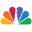
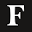
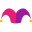
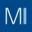
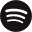
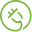
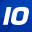
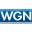
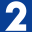
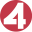
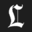
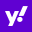
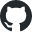
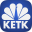
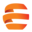
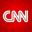
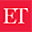
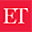
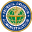
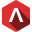
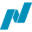
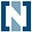
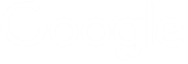
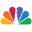
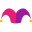
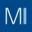
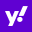
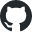

In [5]:
api.get_html_from_url("https://www.google.com/search?q={}+news+on%3A{}&num={}".format('tsla','2023-01-01',25))

In [ ]:
class apiThreadSlave(threading.Thread):
   def __init__(self, thread_id, tag, dates, num_links):
      threading.Thread.__init__(self)
      self.thread_id = thread_id
      self.tag = tag
      self.dates = dates
      self.num_links = num_links
      self.api = APIClient()
   def run(self):
      for i, date in enumerate(self.dates):
         tmpdata = self.api.get_stock_data(self.tag, date,self.num_links)
         if tmpdata.shape[0] > 0:
            tmpdata.to_csv(r'data/{}/{}.csv'.format(self.tag,date))
         print('Thread ID:',self.thread_id,'Link #',i)

In [ ]:
#@title Multithreading
MAX_THREADS = 8
TAG = 'tsla'

dt_rng = pd.date_range(start="2022-01-01", end="2023-01-01").date
n = len(dt_rng) // MAX_THREADS # number of dates per thread
thread_dt_rng = [dt_rng[x * n:(x + 1) * n] for x in range((len(dt_rng) + n - 1) // n )]

threads = []

for i, dates in enumerate(thread_dt_rng):
    tmp_thread = apiThreadSlave(i, TAG, dates, 50)
    tmp_thread.start()
    threads.append(tmp_thread)

for t in threads:
    t.join()

# TESTING

In [ ]:
#url = "https://www.bloomberg.com/news/articles/2023-02-17/summers-says-too-soon-to-call-for-march-50-basis-point-fed-hike?srnd=premium"
#url = "https://www.bloomberg.com/news/articles/2023-02-18/cars-tires-textile-factories-have-shut-in-crisis-hit-pakistan?srnd=industries-v2"

testlinks = api.get_google_links('tsla','2022-02-01',25)
testlinks

In [ ]:
res = api.get_article_data(testlinks[4])
res

In [ ]:
html = api.get_html_from_url(testlinks[0])

In [ ]:
soup = BeautifulSoup(html, 'html.parser')
text = ''
for tmp in [tmp.text for tmp in soup.find_all(['a','p','h','h1','h2'])]:
    if len(tmp) > 25 and re.findall('Click here',tmp) == [] and re.findall('This Simple Trick',tmp) == []:
        text += tmp + ' '
text = re.sub('\s+',' ',text.replace('\n',' ').replace('\xa0',' ').replace('\'','’').replace('   ',' ').strip())
text